# N-body Simulation
by **Collin Sinclair**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from tqdm import tqdm
from src import forces
from src import leapfrog
from src import systems
# %matplotlib qt

## Write Calculation Tools

In [2]:
# 1
forces.test()

This test function should produce the following output:

  particle |         Fx |         Fy |         Fz
       (#) |        (N) |        (N) |        (N)
-------------------------------------------------
         0 |   -1.3e+15 |    3.8e+14 |    3.5e+14
         1 |    9.2e+15 |   -5.3e+16 |    1.8e+15
         2 |    7.5e+16 |    5.4e+16 |   -2.7e+16
         3 |   -4.2e+16 |    6.4e+15 |    1.1e+15
         4 |   -4.0e+16 |   -7.5e+15 |    2.4e+16
    
Here is what it outputs after running calculateForceVectors:

  particle |         Fx |         Fy |         Fz
       (#) |        (N) |        (N) |        (N)
-------------------------------------------------
         0 |   -1.3e+15 |    3.8e+14 |    3.5e+14
         1 |    9.2e+15 |   -5.3e+16 |    1.8e+15
         2 |    7.5e+16 |    5.4e+16 |   -2.7e+16
         3 |   -4.2e+16 |    6.4e+15 |    1.1e+15
         4 |   -4.0e+16 |   -7.5e+15 |    2.4e+16

If those two tables are the same, it works!


In [3]:
# 2
def updateParticles(masses, positions, velocities, dt):
    """
    Evolve particles in time via leap-frog integrator scheme. This function
    takes masses, positions, velocities, and a time step dt as

    Parameters
    ----------
    masses : np.ndarray
        1-D array containing masses for all particles, in kg
        It has length N, where N is the number of particles.
    positions : np.ndarray
        2-D array containing (x, y, z) positions for all particles.
        Shape is (N, 3) where N is the number of particles.
    velocities : np.ndarray
        2-D array containing (x, y, z) velocities for all particles.
        Shape is (N, 3) where N is the number of particles.
    dt : float
        Evolve system for time dt (in seconds).

    Returns
    -------
    Updated particle positions and particle velocities, each being a 2-D
    array with shape (N, 3), where N is the number of particles.

    """

    startingPositions = np.array(positions)
    startingVelocities = np.array(velocities)

    # how many particles are there?
    nParticles, nDimensions = startingPositions.shape

    # make sure the three input arrays have consistent shapes
    assert(startingVelocities.shape == startingPositions.shape)
    assert(len(masses) == nParticles)

    # calculate net force vectors on all particles, at the starting position
    startingForces = np.array(forces.calculateForceVectors(masses, startingPositions))

    # calculate the acceleration due to gravity, at the starting position
    startingAccelerations = startingForces/np.array(masses).reshape(nParticles, 1)

    # calculate the ending position
    nudge = startingVelocities*dt + 0.5*startingAccelerations*dt**2
    endingPositions = startingPositions + nudge

    # calculate net force vectors on all particles, at the ending position
    endingForces = np.array(forces.calculateForceVectors(masses, endingPositions))

    # calculate the acceleration due to gravity, at the ending position
    endingAccelerations = endingForces/np.array(masses).reshape(nParticles, 1)

    # calculate the ending velocity
    endingVelocities = (startingVelocities +
                        0.5*(endingAccelerations + startingAccelerations)*dt)

    return endingPositions, endingVelocities

masses, positions, velocities = systems.SunEarth()
updateParticles(masses, positions, velocities, 100)

(array([[-4.49174720e+05, -8.94399737e+00,  0.00000000e+00],
        [ 1.49599551e+11,  2.97883636e+06,  0.00000000e+00]]),
 array([[ 1.77984608e-06, -8.94399737e-02,  0.00000000e+00],
        [-5.92785306e-01,  2.97883636e+04,  0.00000000e+00]]))

In [4]:
# 3
def calculateTrajectories(masses, positions, velocities, duration, dt):
    
    """
    Evolves particle's positions velocities in time.
    Starts from initial positions and velocities, takes a step forward in time,
    calculates new positions and velocities, stores these new values in arrays,
    and then repeat that process over and over again.
    
    Parameters
    ----------
    masses: 1D array, with nParticles elements
    positions: 2D array, nParticles × nDimensions elements
    velocities: 2D array, nParticles × nDimensions elements
    duration: the total time to evolve the system (a float, in seconds)
    dt: the size of each time step, (a float, in seconds)
    
    Returns
    -------
    times: 1D array, with nTimes elements
    positions at all times: 3D array, nParticles × nDimensions × nTimes
    velocities at all times: 3D array, nParticles × nDimensions × nTimes
    """
    
    startingPositions = np.array(positions)
    startingVelocities = np.array(velocities)
    
    # how many particles are there?
    nParticles, nDimensions = startingPositions.shape
    
    # make sure the three input arrays have consistent shapes
    assert(startingVelocities.shape == startingPositions.shape)
    assert(len(masses) == nParticles)
    
    times = np.arange(0, duration, dt)
    allPositions = np.zeros((nParticles, nDimensions, len(times)))
    allVelocities = np.zeros((nParticles, nDimensions, len(times)))
    
    for i in tqdm(range(len(times))):
        newPositions, newVelocities = updateParticles(masses, positions, velocities, dt)
        allPositions[:,:,i] = newPositions
        allVelocities[:,:,i] = newVelocities
        positions, velocities = newPositions, newVelocities
        
    return times, allPositions, allVelocities

## Earth in (circular) orbit around the Sun

In [5]:
# 4
masses, positions, velocities = systems.SunEarth()
duration = 1000*24*60*60
dt = 0.1*24*60*60
times, allPositions, allVelocities = calculateTrajectories(masses, positions, velocities, duration, dt)

timesInDays = times/(24*60*60)
allPositionsInAU = allPositions/(1.496e11)

100%|██████████| 10000/10000 [00:01<00:00, 8967.12it/s]


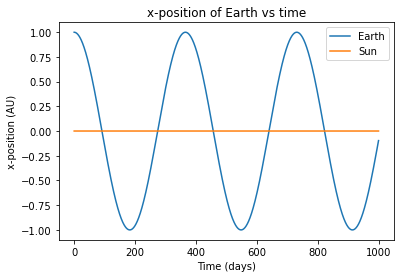

In [6]:
# 5
plt.plot(timesInDays, allPositionsInAU[1,0,:], label='Earth')
plt.plot(timesInDays, allPositionsInAU[0,0,:], label='Sun')
plt.title('x-position of Earth vs time')
plt.xlabel('Time (days)')
plt.ylabel('x-position (AU)')
plt.legend(loc='best');

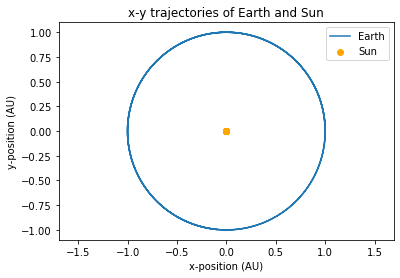

In [7]:
# 5 (continued)
plt.plot(allPositionsInAU[1,0,:], allPositionsInAU[1,1,:], label='Earth')
plt.scatter(allPositionsInAU[0,0,:], allPositionsInAU[0,1,:], label='Sun', color='orange')
plt.title('x-y trajectories of Earth and Sun')
plt.xlabel('x-position (AU)')
plt.ylabel('y-position (AU)')
plt.legend(loc='best');
plt.axis('equal');

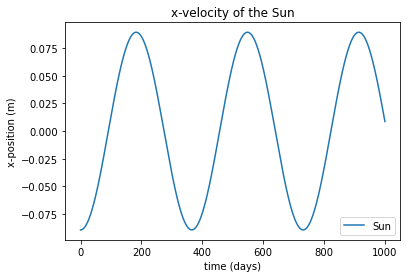

In [8]:
# 5 (continued)
plt.plot(timesInDays, allVelocities[0,1,:], label='Sun')
plt.title('x-velocity of the Sun')
plt.xlabel('time (days)')
plt.ylabel('x-position (m)')
plt.legend(loc='lower right');

100%|██████████| 10000/10000 [00:01<00:00, 8331.45it/s]


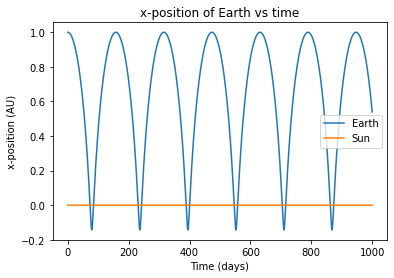

In [9]:
# 6
masses, positions, velocities = systems.SunEarth()
duration = 1000*24*60*60
dt = 0.1*24*60*60
times, allPositions, allVelocities = calculateTrajectories(masses, positions, (velocities/2), duration, dt)

timesInDays = times/(24*60*60)
allPositionsInAU = allPositions/(1.496e11)

plt.plot(timesInDays, allPositionsInAU[1,0,:], label='Earth')
plt.plot(timesInDays, allPositionsInAU[0,0,:], label='Sun')
plt.title('x-position of Earth vs time')
plt.xlabel('Time (days)')
plt.ylabel('x-position (AU)')
plt.legend(loc='best');

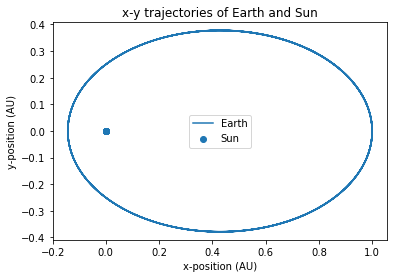

In [10]:
# 6 (continued)
plt.plot(allPositionsInAU[1,0,:], allPositionsInAU[1,1,:], label='Earth')
plt.scatter(allPositionsInAU[0,0,:], allPositionsInAU[0,1,:], label='Sun')
plt.title('x-y trajectories of Earth and Sun')
plt.xlabel('x-position (AU)')
plt.ylabel('y-position (AU)')
plt.legend(loc='best');
plt.axis('equal');

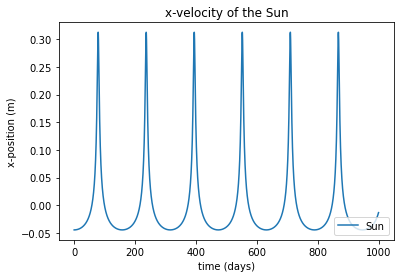

In [11]:
# 6 (continued)
plt.plot(timesInDays, allVelocities[0,1,:], label='Sun')
plt.title('x-velocity of the Sun')
plt.xlabel('time (days)')
plt.ylabel('x-position (m)')
plt.legend(loc='lower right');

## The Circumbinary Exoplanet Kepler-16ABb

In [12]:
# 7
masses, positions, velocities = systems.Kepler16()

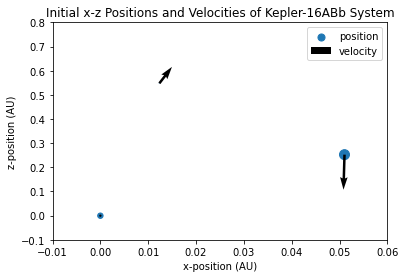

In [13]:
# 8
positionsInAU = positions/(1.496e11)
velocitiesInAU = velocities/(1.496e11)
scale = 100/(np.max(masses))
sizes = scale * masses

plt.scatter(positionsInAU[:][0],positionsInAU[:][2], s=sizes, label='position')
plt.quiver(positionsInAU[:][0], positionsInAU[:][2], velocitiesInAU[:][0], velocitiesInAU[:][2],\
           label='velocity')
plt.xlim(-0.01, 0.06)
plt.ylim(-0.1, 0.8)
plt.title('Initial x-z Positions and Velocities of Kepler-16ABb System')
plt.xlabel('x-position (AU)')
plt.ylabel('z-position (AU)')
plt.legend();

In [14]:
#9
duration = 500*24*3600
dt = 0.5*24*3600

times, allPositions, allVelocities = calculateTrajectories(masses, positions, velocities, duration, dt)

100%|██████████| 1000/1000 [00:00<00:00, 3441.88it/s]


What do you want name your movie? test05151415


100%|██████████| 1000/1000 [01:17<00:00, 12.83it/s]


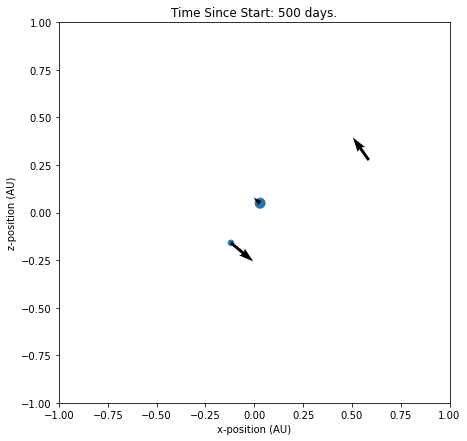

In [15]:
# 10
timesInDays = times/(24*60*60)
positionsInAU = allPositions/(1.496e11)
velocitiesInAU = allVelocities/(1.496e11)

scale = 100/(np.max(masses))
sizes = scale * masses

wri = ani.FFMpegWriter(fps=30)
fig = plt.figure(figsize=(7,7))
with wri.saving(fig, str(input('What do you want name your movie?'))+'.mp4', 400): 
    for i in tqdm(range(len(timesInDays))):
        plt.cla()
        plt.title('Time Since Start: {:.0f} days.'.format(timesInDays[i]))
        plt.scatter(positionsInAU[:,0,i],positionsInAU[:,2,i], s=sizes)
        plt.quiver(positionsInAU[:,0,i], positionsInAU[:,2,i], velocitiesInAU[:,0,i], velocitiesInAU[:,2,i],\
           label='velocity')
        plt.xlabel('x-position (AU)')
        plt.ylabel('z-position (AU)')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        wri.grab_frame()

## Choose Your Own Adventure

In [16]:
# 11
masses, positions, velocities = systems.planetesimalDisk(N=100, z_velocity=7500)

duration = 1000*24*3600
dt = 0.1*24*3600

times, allPositions, allVelocities = calculateTrajectories(masses, positions, velocities, duration, dt)

np.save(str(input('What do you want name your calculations?')),(times, allPositions, allVelocities))

100%|██████████| 10000/10000 [57:18<00:00,  2.91it/s] 


What do you want name your calculations? planetDisk051420211514


/Users/collinsinclair/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


What do you want name your movie? planetDisk051520211515


100%|██████████| 10000/10000 [25:48<00:00,  6.46it/s]


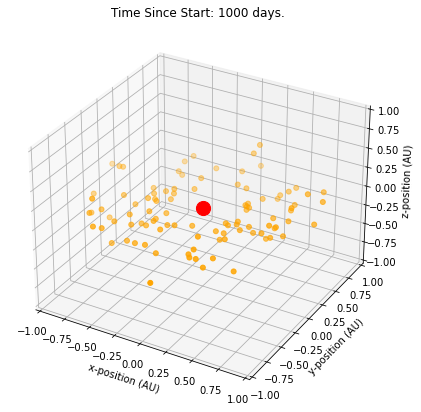

In [17]:
#12

timesInDays = times/(24*3600)
allPositionsInAU = allPositions/(1.496e11)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

wri = ani.FFMpegWriter(fps=100)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
with wri.saving(fig, str(input('What do you want name your movie?'))+'.mp4', 500): 
    for i in tqdm(range(len(timesInDays))):
        ax.cla()
        ax.set_title('Time Since Start: {:.0f} days.'.format(timesInDays[i]))
        ax.scatter(allPositionsInAU[0,0,i],allPositionsInAU[0,1,i],allPositionsInAU[0,2,i], s=200, color='red')
        ax.scatter(allPositionsInAU[1:,0,i],allPositionsInAU[1:,1,i],allPositionsInAU[1:,2,i], s=25, color='orange')
        ax.set_xlabel('x-position (AU)')
        ax.set_ylabel('y-position (AU)')
        ax.set_zlabel('z-position (AU)')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(-1, 1)
        wri.grab_frame()